# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete GFE-constrained SSM.

In [62]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [63]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian
# using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")
;

In [64]:
using ForneyLab: VBTransitionA, unsafeMeanVector
import ForneyLab: outboundType

# Edit: change outboundtype to function
outboundType(::Type{VBTransitionA}) = Message{Function}

# Edit: return log-pdf
function ruleVBTransitionA(dist_out::Distribution,
                           dist_in1::Distribution,
                           dist_a::Nothing)
    B = unsafeMeanVector(dist_out)*unsafeMeanVector(dist_in1)'

    return Message(MatrixVariate, Function, log_pdf=A->tr(B'*log.(A)))
end
;

In [65]:
import ForneyLab: sampleWeightsAndEntropy

# Edit: set to 50 samples
function sampleWeightsAndEntropy(x::Distribution, y::Distribution)
    n_samples = 50 # Number of samples is fixed
    samples = sample(x, n_samples)

    # Apply log-pdf functions to the samples
    log_samples_x = logPdf.([x], samples)
    log_samples_y = logPdf.([y], samples)

    # Extract the sample weights
    w_raw = exp.(log_samples_y) # Unnormalized weights
    w_sum = sum(w_raw)
    weights = w_raw./w_sum # Normalize the raw weights

    # Compute the separate contributions to the entropy
    H_y = log(w_sum) - log(n_samples)
    H_x = -sum( weights.*(log_samples_x + log_samples_y) )
    entropy = H_x + H_y

    # Inform next step about the proposal and integrand to be used in entropy calculation in smoothing
    logproposal = (samples) -> logPdf.([x], samples)
    logintegrand = (samples) -> logPdf.([y], samples)

    return (samples, weights, w_raw, logproposal, logintegrand, entropy)
end
;

# Algorithm for $t=1$

In [66]:
fg_t1 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
DiscreteObservation(x[1], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_1),
                    n_factors=8)
# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
DiscreteObservation(x[2], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_2),
                    n_factors=8)
# Algorithm
q_t1 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t1 = messagePassingAlgorithm(q_t1, id=:t1, free_energy=true)
code_t1 = algorithmSourceCode(algo_t1, free_energy=true)
eval(Meta.parse(code_t1))
;

# Algorithm for $t=2$

In [67]:
fg_t2 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
@RV y[1] ~ Transition(x[1], A)
placeholder(y[1], :y, index=1, dims=(16,))

# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
DiscreteObservation(x[2], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_2),
                    n_factors=8)
# Algorithm
q_t2 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t2 = messagePassingAlgorithm(q_t2, id=:t2, free_energy=true)
code_t2 = algorithmSourceCode(algo_t2, free_energy=true)
eval(Meta.parse(code_t2))
;

# Algorithm for $t=3$ (Learning)

In [68]:
fg_t3 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
@RV y[1] ~ Transition(x[1], A)
placeholder(y[1], :y, index=1, dims=(16,))

# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
@RV y[2] ~ Transition(x[2], A)
placeholder(y[2], :y, index=2, dims=(16,))

# Algorithm
q_t3 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t3 = messagePassingAlgorithm(q_t3, id=:t3, free_energy=true)
code_t3 = algorithmSourceCode(algo_t3, free_energy=true)
eval(Meta.parse(code_t3))
;

## Action-Perception Loop

In [69]:
α = 0.9; c = 2.0 # Reward probability and utility

include("environment.jl")
include("agent_2.jl")
include("helpers.jl")

(A, B, C, D) = constructABCD(α, c)
A_0 = 100.0*(A .+ 0.01) # Prior statistics for A

(execute, observe) = initializeWorld(A, B, C, D) # Let there be a world
(infer, act) = initializeAgent(A_0, B, C, D) # Let there be a constrained agent

# Step through the experimental protocol
G_ts = Vector{Any}(undef, 2)
a = Vector{Int64}(undef, 2)
o = Vector{Vector}(undef, 2)
for t = 1:2
        G_ts[t] = infer(t, a, o)
           a[t] = act(G_ts[t])
                  execute(a[t])
    (o[t], r_t) = observe()
end
infer(3, a, o) # Learn
;

[0.44 0.44 0.01 0.01 0.01 0.01 0.01 0.01; 0.44 0.45 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.78 0.09 0.01 0.01 0.01 0.01; 0.01 0.01 0.1 0.78 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.1 0.79 0.01 0.01; 0.01 0.01 0.01 0.01 0.78 0.09 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.87 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.87; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


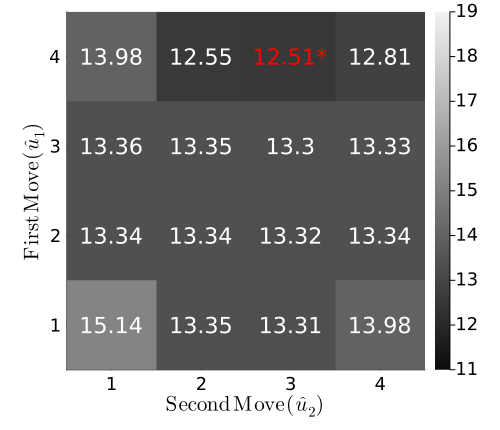

In [73]:
plotResults(G_ts[1], clim=(11,19), highlight=minimum)

In [74]:
G_ts[2]

4-element Vector{Float64}:
  9.291472453865003
 11.680791828079435
  6.442984832725388
  9.104925396779072

In [75]:
a

2-element Vector{Int64}:
 4
 3